# K-Nearest Neighbor Lab





In [21]:
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
import numpy as np
import scipy.io.arff as arff
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder


## 1. (40%) Correctly implement the k-nearest neighbor (KNN) algorithm and the KNN regression algorithm

### Code requirements
- Use Euclidean distance to decide closest neighbors. 
- Include optional distance weighting for both algorithms


In [22]:
class KNNClassifier(BaseEstimator,ClassifierMixin):
    def __init__(self, columntype=[], regression = False, weight_type='inverse_distance', num_neighbour=5): ## add parameters here
        """
        Args:
            columntype for each column tells you if continues[real] or if nominal[categoritcal].
            weight_type: inverse_distance voting or if non distance weighting. Options = ["no_weight","inverse_distance"]
        """
        self.columntype = columntype #Note This won't be needed until part 5
        self.weight_type = weight_type
        self.num_neighbour = num_neighbour
        self.regression = regression
       



    def fit(self, data, labels,Normalize=False):
        """ Fit the data; run the algorithm (for this lab really just saves the data :D)
        Args:
            X (array-like): A 2D numpy array with the training data, excluding targets
            y (array-like): A 2D numpy array with the training targets
        Returns:
            self: this allows this to be chained, e.g. model.fit(X,y).predict(X_test)
        """
        # Make a deep copy of the data
        self.data = np.copy(data)
        self.labels = np.copy(labels)
        #if normalize

        # Normalize the data using column-wise mins and maxes
        if(Normalize):
            self.min_vals = np.min(self.data, axis=0)
            self.max_vals = np.max(self.data, axis=0)

            self.data = (self.data - self.min_vals) / (self.max_vals - self.min_vals)
        return self
    
    def predict(self, data, Normalize=False):
        """ Predict all classes for a dataset X
        Args:
            X (array-like): A 2D numpy array with the training data, excluding targets
        Returns:
            array, shape (n_samples,)
                Predicted target values per element in X.
        """
        predictions = []
        #if normalize
        if(Normalize):
            data = (data - self.min_vals) / (self.max_vals - self.min_vals)
        
        for row in data:
            # Calculate distances between this row and the data saved in fit
            distances =  np.array([self.heom_distance(row, data_point, self.columntype) for data_point in self.data])
            k_indices = np.argsort(distances)[:self.num_neighbour]
            # Sort distances and grab the k nearest neighbors
            #argsort
            k_nearest_labels = self.labels[k_indices]
            # Figure out the vote of the kNN
            if self.regression:
                if self.weight_type == "inverse_distance":
                    weights = 1 / (distances[k_indices] ** 2 + 1e-10)
                    vote = np.sum(weights * k_nearest_labels) / np.sum(weights)
                else:
                    vote = np.mean(k_nearest_labels.astype(float))
            else:
                if self.weight_type == "inverse_distance":
                    weights = 1 / (distances[k_indices] ** 2 + 1e-10)
                    label_weights = {}
                    for i, label in enumerate(k_nearest_labels):
                        label_tuple = tuple(label)
                        if label_tuple not in label_weights:
                            label_weights[label_tuple] = 0
                            
                        label_weights[label_tuple] += weights[i]
                    
                    vote = max(label_weights, key=label_weights.get)
                else:
                    unique_labels, counts = np.unique(k_nearest_labels, return_counts=True, axis=0)
                    vote = unique_labels[np.argmax(counts)]
           
            
            # Append to prediction list
            predictions.append(vote)
        
        # Return all predictions
        return np.array(predictions)
    
    #Returns the Mean score given input data and labels
    def score(self, X, y,mse=False,Normalize=False):
        """ Return accuracy of model on a given dataset. Must implement own score function.
        Args:
            X (array-like): A 2D numpy array with data, excluding targets
            y (array-like): A 2D numpy array with targets
        Returns:
            score : float
                Mean accuracy of self.predict(X) wrt. y.
        """
        predictions = self.predict(X,Normalize)
        #print(y)
    
        if mse:
            sse = 0
            for i in range(len(predictions)):
                sse += ((float(predictions[i]) - (float(y[i][0])))**2)
            return sse / len(predictions)
            #return np.square(np.subtract(y,predictions)).mean()
        else:
            return np.mean(predictions == y)
    
    def heom_distance(self, x, y, column_types):
        distance = 0
        for i, column_type in enumerate(column_types):
            if x[i] == "?" or y[i] == "?":
                continue
            if column_type == "continuous":
                distance += (x[i] - y[i]) ** 2
            else:
                distance += 1 if x[i] != y[i] else 0
        return np.sqrt(distance)

## 1.1 Debug and Evaluation

Debug and Evaluate your model using the parameters below:

- Use distance weighting
- KNN = 3 (three nearest neighbors)
- Don’t normalize the data
- Use Euclidean Distance

---

### 1.1.1 Debug

- Use this [glass training set](https://byu.instructure.com/courses/14142/files?preview=4660939) and this [glass test set](https://byu.instructure.com/courses/14142/files?preview=4660941)
- Use distance weighting
- KNN = 3 (three nearest neighbors)
- Don’t normalize the data
- Use Euclidean Distance

Expected Results:
- Not using inverse weighted distancing = roughly [68.29%]
- Link to [glass no_inverse debug solution](https://byu.instructure.com/courses/14142/files?preview=4660947)

- Using inverse weighted distancing = roughly [74.39%]
- Link to [glass inverse debug solution](https://byu.instructure.com/courses/14142/files?preview=4660954)


In [71]:
# Load glass data

# Train on training set

# Predict on test set
mat, meta = arff.loadarff('glass_train.arff')
mat = mat.tolist()
labels = []
data = []
for i in range(len(mat)):
    labels.append([mat[i][-1]])
    data.append(mat[i][:-1])
mat, meta = arff.loadarff('glass_test.arff')
mat = mat.tolist()
labels_test = []
data_test = []
for i in range(len(mat)):
    labels_test.append([mat[i][-1]])
    data_test.append(mat[i][:-1])


KNN = KNNClassifier(weight_type='inverse_distance', num_neighbour=3, regression=False)
data = np.array(data)
labels = np.array(labels)
data_test = np.array(data_test)
labels_test = np.array(labels_test)
print(KNN.fit(data, labels,Normalize=False))
print(KNN.score(data_test, labels_test, mse=False,Normalize=False))

KNN = KNNClassifier(weight_type='distance', num_neighbour=3, regression=False)
data = np.array(data)
labels = np.array(labels)
data_test = np.array(data_test)
labels_test = np.array(labels_test)
print(KNN.fit(data, labels,Normalize=False))
print(KNN.score(data_test, labels_test, mse=False,Normalize=False))




KNNClassifier(num_neighbour=3)
0.7439024390243902
KNNClassifier(num_neighbour=3, weight_type='distance')
0.6829268292682927


### 1.1.2 Evaluate

We will evaluate your model based on its performance on the [diabetes](https://archive.ics.uci.edu/ml/datasets/Diabetes) problem.
- Use this [diabetes training set](https://byu.instructure.com/courses/14142/files?preview=4660977) and this [diabetes test set](https://byu.instructure.com/courses/14142/files?preview=4660978)

In [73]:
# Load diabetes data


# Train on training set
mat, meta = arff.loadarff('diabetes_train.arff')
mat = mat.tolist()
labels = []
data = []
for i in range(len(mat)):
    labels.append([mat[i][-1]])
    data.append(mat[i][:-1])
mat, meta = arff.loadarff('diabetes_test.arff')
mat = mat.tolist()
labels_test = []
data_test = []
for i in range(len(mat)):
    labels_test.append([mat[i][-1]])
    data_test.append(mat[i][:-1])

# Predict on test set
KNN = KNNClassifier(weight_type='inverse_distance', num_neighbour=3, regression=False)
data = np.array(data)
labels = np.array(labels)
data_test = np.array(data_test)
labels_test = np.array(labels_test)
print(KNN.fit(data, labels,Normalize=False))
print(KNN.score(data_test, labels_test, mse=False,Normalize=False))


KNNClassifier(num_neighbour=3)
0.890625


## 2. (10%) Use the k-nearest neighbor algorithm (without distance weighting) for the [magic telescope](http://archive.ics.uci.edu/ml/datasets/MAGIC+Gamma+Telescope) problem

- Use this [magic telescope training set](https://byu.instructure.com/courses/14142/files?preview=4660988) and this [magic telescope test set](https://byu.instructure.com/courses/14142/files?preview=4660989) 

### 2.1
- Try it with k=3 and without normalization


In [124]:
# Load magic telescope data

# Train/Predict without normalization
# Load diabetes data


# Train on training set
mat, meta = arff.loadarff('magic_telescope_train.arff')
mat = mat.tolist()
labels = []
data = []
for i in range(len(mat)):
    labels.append([mat[i][-1]])
    data.append(mat[i][:-1])
mat, meta = arff.loadarff('magic_telescope_test.arff')
mat = mat.tolist()
labels_test = []
data_test = []
for i in range(len(mat)):
    labels_test.append([mat[i][-1]])
    data_test.append(mat[i][:-1])

# Predict on test set
KNN = KNNClassifier(weight_type='distance', num_neighbour=3, regression=False)
data = np.array(data)
labels = np.array(labels)
data_test = np.array(data_test)
labels_test = np.array(labels_test)
print(KNN.fit(data, labels,Normalize=False))
print(KNN.score(data_test, labels_test, mse=False,Normalize=False))



KNNClassifier(num_neighbour=3, weight_type='distance')
0.8082808280828083


### 2.2
- Try it with k=3 and with normalization (input features normalized between 0 and 1). Use the normalization formula (x-xmin)/(xmax-xmin)

In [125]:
# Train/Predict with normalization
mat, meta = arff.loadarff('magic_telescope_train.arff')
mat = mat.tolist()
labels = []
data = []
for i in range(len(mat)):
    labels.append([mat[i][-1]])
    data.append(mat[i][:-1])
mat, meta = arff.loadarff('magic_telescope_test.arff')
mat = mat.tolist()
labels_test = []
data_test = []
for i in range(len(mat)):
    labels_test.append([mat[i][-1]])
    data_test.append(mat[i][:-1])

# Predict on test set
KNN = KNNClassifier(weight_type='distance', num_neighbour=3, regression=False)
data = np.array(data)
labels = np.array(labels)
data_test = np.array(data_test)
labels_test = np.array(labels_test)
print(KNN.fit(data, labels,Normalize=True))
print(KNN.score(data_test, labels_test, mse=False,Normalize=True))

KNNClassifier(num_neighbour=3, weight_type='distance')
0.8306330633063307


The accuracy results show a difference when using normalized data versus unnormalized data in the K-nearest neighbor (KNN) classifier. Specifically, the classifier's accuracy is higher when using normalized data, with a score of 0.8306, compared to the accuracy of 0.8083 when using unnormalized data. I think the reason behind this difference in accuracy lies in KNN algorithm. KNN relies on the calculation of distances between data points to make predictions. When features within the dataset have different scales or units, the distance metric may be dominated by the feature with the largest scale. This can lead to suboptimal predictions, as the impact of other features with smaller scales might be neglected. By normalizing the data, I ensure that all features have the same scale or are within the same range.This equalizes the influence of each feature on the distance metric and allows the KNN algorithm to make better predictions.

### 2.3

- Using your normalized data, create one graph with classification accuracy on the test set over k values. 
    - Use odd values of k from 1 to 15.
- As a rough sanity check, typical knn accuracies for the magic telescope data set are 75-85%

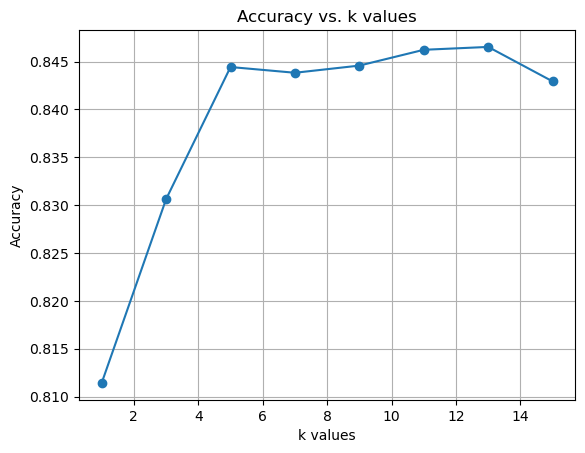

In [130]:
# Train/Predict with normalization using k=1,3,...,15

# Graph classification accuracy over k


# Train/Predict with normalization
mat, meta = arff.loadarff('magic_telescope_train.arff')
mat = mat.tolist()
labels = []
data = []
for i in range(len(mat)):
    labels.append([mat[i][-1]])
    data.append(mat[i][:-1])
mat, meta = arff.loadarff('magic_telescope_test.arff')
mat = mat.tolist()
labels_test = []
data_test = []
for i in range(len(mat)):
    labels_test.append([mat[i][-1]])
    data_test.append(mat[i][:-1])


k_values = list(range(1, 16, 2))
accuracies = []

# Loop through odd k values and calculate the accuracy
for k in k_values:
    KNN = KNNClassifier(weight_type='distance', num_neighbour=k, regression=False)
    KNN.fit(data, labels, Normalize=True)
    accuracy = KNN.score(data_test, labels_test, mse=False, Normalize=True)
    accuracies.append(accuracy)

# Plot the results
plt.plot(k_values, accuracies, marker='o')
plt.xlabel('k values')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. k values')
plt.grid()
plt.show()


# For the rest of the experiments use only normalized data

## 3. (10%) Use the regression variation of your algorithm (without distance weighting) for the [housing price prediction](https://www.cs.toronto.edu/~delve/data/boston/bostonDetail.html) problem.

- Use this [housing training set](https://byu.instructure.com/courses/14142/files?preview=4660994) and this [housing test set](https://byu.instructure.com/courses/14142/files?preview=4660995).
- Use Mean Square Error (MSE) on the test set as your accuracy metric for this case.
    - Do not normalize regression output values
- Graph MSE on the test set with odd values of k from 1 to 15


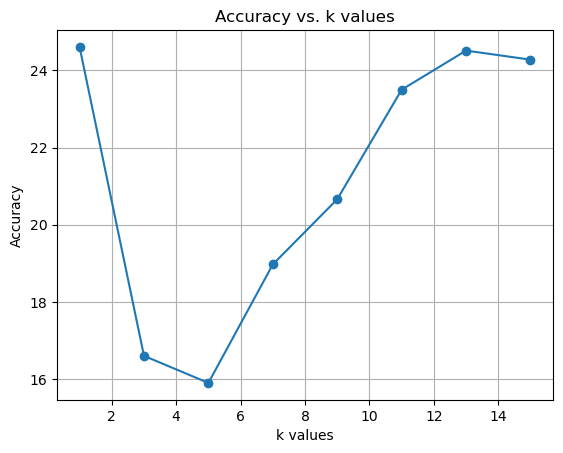

In [5]:
# Load housing price prediction data

# Train/Predict using k=1,3,...,15

# Graph MSE over k
# Train/Predict with normalization using k=1,3,...,15

# Graph classification accuracy over k


# Train/Predict with normalization
mat, meta = arff.loadarff('housing_train.arff')
mat = np.array(mat.tolist(), dtype=float) # Convert the entire dataset to numerical format
labels = mat[:, -1].reshape(-1, 1)
data = mat[:, :-1]

mat, meta = arff.loadarff('housing_test.arff')
mat = np.array(mat.tolist(), dtype=float) # Convert the entire dataset to numerical format
labels_test = mat[:, -1].reshape(-1, 1)
data_test = mat[:, :-1]


k_values = list(range(1, 16, 2))
accuracies = []

# Loop through odd k values and calculate the accuracy
for k in k_values:
    KNN = KNNClassifier(weight_type='distance', num_neighbour=k, regression=True)
    KNN.fit(data, labels, Normalize=True)
    accuracy = KNN.score(data_test, labels_test, mse=True, Normalize=True)
    #print()
    accuracies.append(accuracy)

# Plot the results
plt.plot(k_values, accuracies, marker='o')
plt.xlabel('k values')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. k values')
plt.grid()
plt.show()



## 4. (15%) Repeat your experiments for magic telescope and housing using distance-weighted (inverse of distance squared) voting and discuss your results.


## 4.1 Magic Telescope Dataset

In [97]:
# Train/Predict magic telescope using distance-weighted voting
# Train/Predict with normalization
mat, meta = arff.loadarff('magic_telescope_train.arff')
mat = mat.tolist()
labels = []
data = []
for i in range(len(mat)):
    labels.append([mat[i][-1]])
    data.append(mat[i][:-1])
mat, meta = arff.loadarff('magic_telescope_test.arff')
mat = mat.tolist()
labels_test = []
data_test = []
for i in range(len(mat)):
    labels_test.append([mat[i][-1]])
    data_test.append(mat[i][:-1])

# Predict on test set
KNN = KNNClassifier(weight_type='distance', num_neighbour=3, regression=False)
data = np.array(data)
labels = np.array(labels)
data_test = np.array(data_test)
labels_test = np.array(labels_test)
print(KNN.fit(data, labels,Normalize=True))
print(KNN.score(data_test, labels_test, mse=False,Normalize=True))

KNNClassifier(num_neighbour=3, weight_type='distance')
0.8306330633063307


## 4.2 Housing Dataset

In [129]:
# Train/Predict housing using distance-weighted voting
# Train/Predict magic telescope using distance-weighted voting
# Train/Predict with normalization
mat, meta = arff.loadarff('housing_train.arff')
mat = np.array(mat.tolist(), dtype=float) # Convert the entire dataset to numerical format
labels = mat[:, -1].reshape(-1, 1)
data = mat[:, :-1]

mat, meta = arff.loadarff('housing_test.arff')
mat = np.array(mat.tolist(), dtype=float) # Convert the entire dataset to numerical format
labels_test = mat[:, -1].reshape(-1, 1)
data_test = mat[:, :-1]

# Predict on test set
KNN = KNNClassifier(weight_type='invert_distance', num_neighbour=3, regression=True)
print(KNN.fit(data, labels, Normalize=False))
print(KNN.score(data_test, labels_test, mse=True, Normalize=False))

KNNClassifier(num_neighbour=3, regression=True, weight_type='invert_distance')
52.963246187363836


From these results, we can observe that the magic telescope classifier has a relatively high accuracy(83.06%), which can be attributed to the combination of data normalization and distance-weighted voting. Data normalization ensures that all features contribute equally to the distance calculation, while distance-weighted voting helps to weigh the contribution of each neighbor based on their distance from the query point. For the housing dataset, the KNN classifier uses distance-weighted voting with inverted distance but without data normalization. The MSE score is 52.9632, which is good considering that we want a low MSE.A low MSE signifies that the model is making fewer errors in its predictions. 

## 5. (10%) Use the k-nearest neighbor algorithm to solve the [credit-approval](https://archive.ics.uci.edu/ml/datasets/Credit+Approval) (credit-a) problem.

- Use this [credit approval dataset](https://byu.instructure.com/courses/14142/files?preview=4660998)
    - Use a 70/30 split of the data for the training/test set
- Note that this set has both continuous and nominal attributes, together with don’t know values. 
- Implement and justify a distance metric which supports continuous, nominal, and don’t know attribute values
    - You need to handle don't knows with the distance metric, not by imputing a value.
    - More information on distance metrics can be found [here](https://www.jair.org/index.php/jair/article/view/10182/24168).
- Use your own choice for k.
- As a rough sanity check, typical knn accuracies for the credit data set are 70-80%.


In [23]:
# Load dataset and split into train/test sets

# Train/Predict credit-approval
# Train/Predict housing using distance-weighted voting
# Train/Predict magic telescope using distance-weighted voting
# Train/Predict with normalization
mat, meta = arff.loadarff('credit_approval.arff')
mat = np.array(mat.tolist(), dtype=object) # Convert the entire dataset to an object dtype array
labels = mat[:, -1].reshape(-1, 1)
data = mat[:, :-1]

# Encode labels as numbers
encoder = LabelEncoder()
labels = encoder.fit_transform(labels).reshape(-1, 1)
# Split the dataset into a 70/30 training/test set
data_train, data_test, labels_train, labels_test = train_test_split(data, labels, test_size=0.3)

# Fit and score on the training set
KNN = KNNClassifier(weight_type='inverse_distance', num_neighbour=3, regression=True)
KNN.fit(data_train, labels_train, Normalize=False)
print(KNN.score(data_train, labels_train, mse=True, Normalize=False))




C:\Users\Public\Documents\Anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.44306418219461696


I used the Heterogeneous Euclidean-Overlap Metric (HEOM) for my distance metric because it is particularly suitable for datasets with a mix of continuous, nominal (categorical), and missing (don't know) attribute values. HEOM works by calculating the distance between two data points by considering the differences in each attribute according to its type. it combines Euclidean distance for continuous attributes and overlap distance for nominal attributes.
I followed this methodology when creating my HEOM function:
-For continuous attributes, the squared difference between the attribute values is added to the distance. If the attribute type is continuous, you calculate the squared difference between the attribute values and add it to the distance.
-For nominal attributes, the distance is incremented by 1 if the attribute values are different, and 0 if they are the same. If the attribute type is nominal (categorical), you increment the distance by 1 if the attribute values are different, and 0 if they are the same.
-For missing (don't know) attributes, they are simply ignored in the distance calculation. If the attribute value is missing (represented by '?'), you skip the attribute by using continue.
-Return the square root of the distance, which is consistent with the Euclidean distance calculation for continuous attributes.



## 6. (15%) Use the scikit's KNN Classifier on magic telescope and KNN Regressor on housing and compare your results.

- Try out different hyperparameters to see how well you can do. 


In [33]:
import numpy as np
from scipy.io import arff
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.metrics import accuracy_score, mean_squared_error

# Train/Predict magic telescope using scikit's KNN
mat, meta = arff.loadarff('magic_telescope_train.arff')
mat = mat.tolist()
labels = []
data = []
for i in range(len(mat)):
    labels.append([mat[i][-1]])
    data.append(mat[i][:-1])
mat, meta = arff.loadarff('magic_telescope_test.arff')
mat = mat.tolist()
labels_test = []
data_test = []
for i in range(len(mat)):
    labels_test.append([mat[i][-1]])
    data_test.append(mat[i][:-1])


knn_classifier = KNeighborsClassifier(n_neighbors=3, weights='distance')
knn_classifier.fit(data, labels)
labels_pred = knn_classifier.predict(data_test)
accuracy = accuracy_score(labels_test, labels_pred)
print(f'Magic Telescope KNeighborsClassifier accuracy: {accuracy}')



# Train/Predict housing using scikit's KNN

mat, meta = arff.loadarff('housing_train.arff')
mat = np.array(mat.tolist(), dtype=float) # Convert the entire dataset to numerical format
labels = mat[:, -1].reshape(-1, 1)
data = mat[:, :-1]

mat, meta = arff.loadarff('housing_test.arff')
mat = np.array(mat.tolist(), dtype=float) # Convert the entire dataset to numerical format
labels_test = mat[:, -1].reshape(-1, 1)
data_test = mat[:, :-1]

knn_regressor = KNeighborsRegressor(n_neighbors=3, weights='distance')
knn_regressor.fit(data, labels)
labels_pred = knn_regressor.predict(data_test)
mse = mean_squared_error(labels_test, labels_pred)
print(f'Housing KNeighborsRegressor mean squared error: {mse}')


C:\Users\Public\Documents\Anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


Magic Telescope KNeighborsClassifier accuracy: 0.8094809480948095
Housing KNeighborsRegressor mean squared error: 52.76725157580182


Magic Telescope Dataset:
Custom KNNClassifier: 0.8306 (accuracy)
Scikit-learn KNeighborsClassifier: 0.8095 (accuracy)

Housing Dataset:
Custom KNNRegressor: 52.9632 (mean squared error)
Scikit-learn KNeighborsRegressor: 52.7673 (mean squared error)

For the Magic Telescope dataset, my custom KNNClassifier performs slightly better in terms of accuracy (0.8306) compared to the scikit-learn KNeighborsClassifier (0.8095). For the Housing dataset, the mean squared error (MSE) scores are quite close between my custom KNNRegressor (52.9632) and scikit-learn's KNeighborsRegressor (52.7673).  Overall, the results are quite similar to each other which makes me think that my custom KNNClassifier was correctly implemented.


## 7. (optional 5% extra credit): For the best value of k for any one of the datasets, implement a reduction algorithm that removes data points in some rational way such that performance does not drop too drastically on the test set given the reduced training set.

- Compare your performance on the test set for the reduced and non-reduced versions and give the number (and percentage) of training examples removed from the original training set. How well does your reduction algorithm work?
    - Note that performance for magic telescope is classification accuracy and for housing it is mean squared error.
    - Magic Telescope has about 12,000 instances and if you use a leave one out style of testing for your data set reduction, then your algorithm will run slow since that is n2 at each step.
    - If you wish, you may use a random subset of 2,000 of the magic telescope instances.
    - Examples of reduction techniques include: (a) leave-one-out reduction - Drop instance if it would still be classified correctly, (b) growth algorithm - Only add instance if it is not already classified correctly, (c) just keep central points, (d) just keep border points, etc. (see Wilson, D. R. and Martinez, T. R., Reduction Techniques for Exemplar-Based Learning Algorithms, Machine Learning Journal, vol. 38, no. 3, pp. 257-286, 2000).